In [1]:
library(DESeq2)
library(ggplot2)
library(ChIPseeker)
library(GenomicRanges)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(org.Hs.eg.db) # gene annotation 

library(cowplot)
library(tidyverse)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loa

In [2]:
# Read the file
peak_data <- read.table("the.matrix.peaks_and_counts.method1.csv", 
                 header = TRUE, 
                 sep = ",",    # Use sep = "\t" if it's a tab-separated file
                 stringsAsFactors = FALSE)

# View structure
str(peak_data)
head(peak_data, 2)
tail(peak_data, 2)

'data.frame':	30964 obs. of  14 variables:
 $ chr             : chr  "chr1" "chr1" "chr1" "chr1" ...
 $ start           : int  16736 189979 631077 632840 634242 812808 821013 822058 904855 905846 ...
 $ end             : int  17109 190109 631244 632991 634459 813023 821272 822556 905637 906073 ...
 $ strand          : chr  "*" "*" "*" "*" ...
 $ name            : chr  "peak_0" "peak_1" "peak_2" "peak_3" ...
 $ score           : int  649 1000 1000 1000 1000 989 771 476 1000 1000 ...
 $ signalValue     : num  243 209 399 271 252 ...
 $ pValue          : num  3.6 4.34 5.55 5.13 3.82 ...
 $ qValue          : int  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 ...
 $ peak            : int  292 99 88 64 116 49 167 313 316 121 ...
 $ X16h_A27_13_1   : int  8 7 18 10 14 4 6 7 49 15 ...
 $ X16h_A27_13_2   : int  7 6 20 4 1 6 8 23 40 19 ...
 $ X16h_A27_Cis13_1: int  98 48 260 25 17 39 43 167 175 58 ...
 $ X16h_A27_Cis13_2: int  75 62 170 19 12 28 54 105 176 88 ...


,chr,start,end,strand,name,score,signalValue,pValue,qValue,peak,X16h_A27_13_1,X16h_A27_13_2,X16h_A27_Cis13_1,X16h_A27_Cis13_2
,<chr>,<int>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>
1,chr1,16736,17109,*,peak_0,649,242.9123,3.596012,-1,292,8,7,98,75
2,chr1,189979,190109,*,peak_1,1000,208.6019,4.341933,-1,99,7,6,48,62


,chr,start,end,strand,name,score,signalValue,pValue,qValue,peak,X16h_A27_13_1,X16h_A27_13_2,X16h_A27_Cis13_1,X16h_A27_Cis13_2
,<chr>,<int>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>
30963,chrM,10976,11904,*,peak_30962,515,478.6281,3.666109,-1,482,80226,74845,636195,576706
30964,chrM,12886,13195,*,peak_30963,660,204.6618,3.161479,-1,88,14794,15932,134277,120790


In [3]:
# Peak Annotation

In [4]:
peaks_signal200 <- subset(peak_data, signalValue >= 200)
peaks_signal300 <- subset(peak_data, signalValue >= 300)
peaks_signal400 <- subset(peak_data, signalValue >= 400)

# Check the number of peaks in each subset
cat("Peaks with signal ≥ 200:", nrow(peaks_signal200), "\n")
cat("Peaks with signal ≥ 300:", nrow(peaks_signal300), "\n")
cat("Peaks with signal ≥ 400:", nrow(peaks_signal400), "\n")


peaks = peaks_signal400 
head(peaks_signal400)
dim(peaks_signal400)

Peaks with signal ≥ 200: 30964 
Peaks with signal ≥ 300: 18144 
Peaks with signal ≥ 400: 11994 


,chr,start,end,strand,name,score,signalValue,pValue,qValue,peak,X16h_A27_13_1,X16h_A27_13_2,X16h_A27_Cis13_1,X16h_A27_Cis13_2
,<chr>,<int>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>
9,chr1,904855,905637,*,peak_8,1000,1019.6869,6.560973,-1,316,49,40,175,176
11,chr1,907757,908089,*,peak_10,1000,401.6661,5.604062,-1,110,14,11,78,58
16,chr1,923326,923621,*,peak_15,1000,590.2833,5.698771,-1,187,17,12,33,35
17,chr1,923944,925234,*,peak_16,1000,3103.5669,8.732809,-1,445,127,130,378,436
20,chr1,956842,957420,*,peak_19,1000,951.4952,6.953649,-1,55,2031,2080,10267,7844
22,chr1,961318,961692,*,peak_21,1000,528.8220,5.114330,-1,157,26,23,171,144


[1] 11994    14

     score         signalValue         pValue           qValue  
 Min.   : 306.0   Min.   : 400.0   Min.   : 3.281   Min.   :-1  
 1st Qu.:1000.0   1st Qu.: 483.4   1st Qu.: 5.341   1st Qu.:-1  
 Median :1000.0   Median : 624.5   Median : 6.101   Median :-1  
 Mean   : 975.4   Mean   : 827.1   Mean   : 6.382   Mean   :-1  
 3rd Qu.:1000.0   3rd Qu.: 944.8   3rd Qu.: 7.145   3rd Qu.:-1  
 Max.   :1000.0   Max.   :9374.2   Max.   :27.662   Max.   :-1  
      peak       
 Min.   :   2.0  
 1st Qu.: 105.0  
 Median : 184.0  
 Mean   : 250.7  
 3rd Qu.: 332.0  
 Max.   :2384.0  

Warning message:
“Removed 10 rows containing missing values or values outside the scale range (`geom_point()`).”


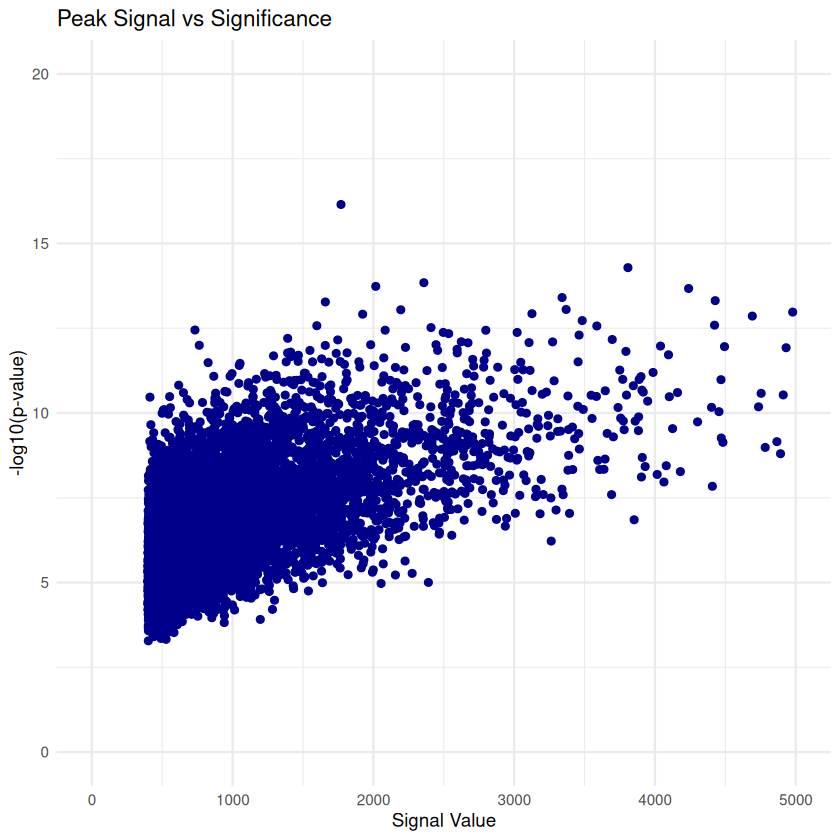

In [5]:
library(ggplot2)

# Select the relevant columns
summary_data <- peaks[, c("score", "signalValue", "pValue", "qValue", "peak")]
# Display summary statistics
summary(summary_data)

# Plot: Signal Value vs pValue
ggplot(peaks, aes(x = signalValue, y = pValue)) +
  geom_point(color = "darkblue") +
  labs(x = "Signal Value", y = "-log10(p-value)", title = "Peak Signal vs Significance") +
  theme_minimal() + 
  xlim(0, 5000) +
  ylim(0, 20)

In [6]:
library(ChIPseeker)
library(GenomicRanges)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(org.Hs.eg.db) # For gene annotation 
# c(-1000, 100)	Core promoter	Strict promoter-only binding

txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene

# Define the TSS region (e.g., -3kb to +3kb around the TSS)
# Adjust these values based on your biological question

# tssRegion <- c(-3000, 100)
tssRegion <- c(-3000, 0)

factor-Rle of length 11170 with 20 runs
  Lengths:  1115   649   580   315   409 ...   710   890   138  1502   361
  Values : chr1  chr2  chr3  chr4  chr5  ... chr16 chr17 chr18 chr19 chrX 
Levels(24): chr1 chr2 chr3 chr4 chr5 chr6 ... chr19 chr20 chr21 chr22 chrX chrM

factor-Rle of length 11170 with 20 runs
  Lengths:  1115   649   580   315   409 ...   710   890   138  1502   361
  Values : chr1  chr2  chr3  chr4  chr5  ... chr16 chr17 chr18 chr19 chrX 
Levels(24): chr1 chr2 chr3 chr4 chr5 chr6 ... chr19 chr20 chr21 chr22 chrX chrM

>> preparing features information...		 2025-07-04 10:13:06 AM 
>> identifying nearest features...		 2025-07-04 10:13:07 AM 
>> calculating distance from peak to TSS...	 2025-07-04 10:13:07 AM 
>> assigning genomic annotation...		 2025-07-04 10:13:07 AM 
>> adding gene annotation...			 2025-07-04 10:13:25 AM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2025-07-04 10:13:25 AM 
>> done...					 2025-07-04 10:13:25 AM 
[1] "the annotation of the peaks:"


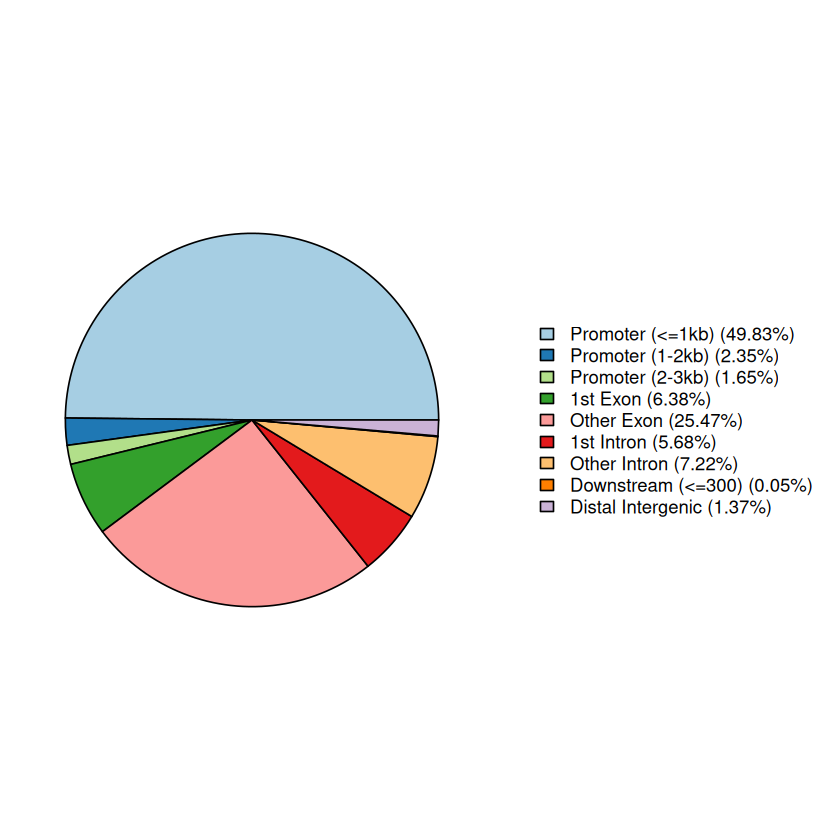

In [7]:
peaks_gr <- GRanges(
  seqnames = peaks$chr,
  ranges = IRanges(start = peaks$start, end = peaks$end),
  strand = peaks$strand,
  mcols = peaks[, c("name", "score", "signalValue", "pValue", "qValue", "peak", 
                  "X16h_A27_13_1", "X16h_A27_13_2",
                  "X16h_A27_Cis13_1", "X16h_A27_Cis13_2")] # metadata columns
)

# Keep peaks on the canonical chromosomes
canonical_chrs <- paste0("chr", c(1:19, "X", "Y"))
peaks_gr_canonical <- peaks_gr[seqnames(peaks_gr) %in% canonical_chrs]

peaks_gr = peaks_gr_canonical
seqnames(peaks_gr)

# Introducing a second variable
gr_peaks = peaks_gr
seqnames(gr_peaks)

# Annotate peaks
tssRegion <- c(-3000, 0)

# Custom order (example: prioritize Exon over UTRs)
my_priority <- c("Promoter", "Exon", "5UTR", "3UTR", "Intron", "Downstream", "Intergenic")

peak_anno <- annotatePeak(
    peak = peaks_gr,
    tssRegion = tssRegion,
    TxDb = txdb,
    # Use OrgDb for gene symbol mapping if desired
    annoDb = "org.Hs.eg.db",
    genomicAnnotationPriority = my_priority,
    verbose = TRUE
  )

print("the annotation of the peaks:")
plotAnnoPie(peak_anno)

# write the peak_annotation into an external file
write.csv(peak_anno, "the.matrix.peaks_and_counts.method1.peak.annotations.ChIPSeekR.csv", row.names = FALSE)

# print("Promoters regions located within 1 kilobase (kb) of a Transcription Start Site (TSS)")
# "Promoter (1-2kb)" means peaks falling between 1kb and 2kb from the TSS.
# "Promoter (2-3kb)" means peaks falling between 2kb and 3kb from the TSS.

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 320 out-of-bound ranges located on sequences
  chr1_GL383518v1_alt, chr1_KI270762v1_alt, chr2_GL383522v1_alt,
  chr2_KI270774v1_alt, chr2_KI270894v1_alt, chr3_KI270777v1_alt,
  chr3_KI270781v1_alt, chr3_KI270782v1_alt, chr4_GL000257v2_alt,
  chr4_KI270788v1_alt, chr4_KI270896v1_alt, chr5_GL339449v2_alt,
  chr5_KI270795v1_alt, chr5_KI270898v1_alt, chr6_GL000250v2_alt,
  chr6_GL000254v2_alt, chr6_KI270797v1_alt, chr6_KI270798v1_alt,
  chr6_KI270801v1_alt, chr7_GL383534v2_alt, chr7_KI270803v1_alt,
  chr7_KI270806v1_alt, chr7_KI270808v1_alt, chr7_KI270809v1_alt,
  chr8_KI270815v1_alt, chr8_KI270817v1_alt, chr9_GL383540v1_alt,
  chr9_GL383541v1_alt, chr9_GL383542v1_alt, chr9_KI270823v1_alt,
  chr10_GL383546v1_alt, chr11_KI270831v1_alt, chr11_KI270902v1_alt,
  chr12_GL383551v1_alt, chr12_GL383553v2_alt, chr12_GL877875v1_alt,
  chr12_KI270834v1_alt, chr13_KI270838v1_alt, chr14_KI270847v1_alt,
  ch


      3UTR       5UTR       exon intergenic     intron   promoter 
       698        834        951        139       1242       7306 


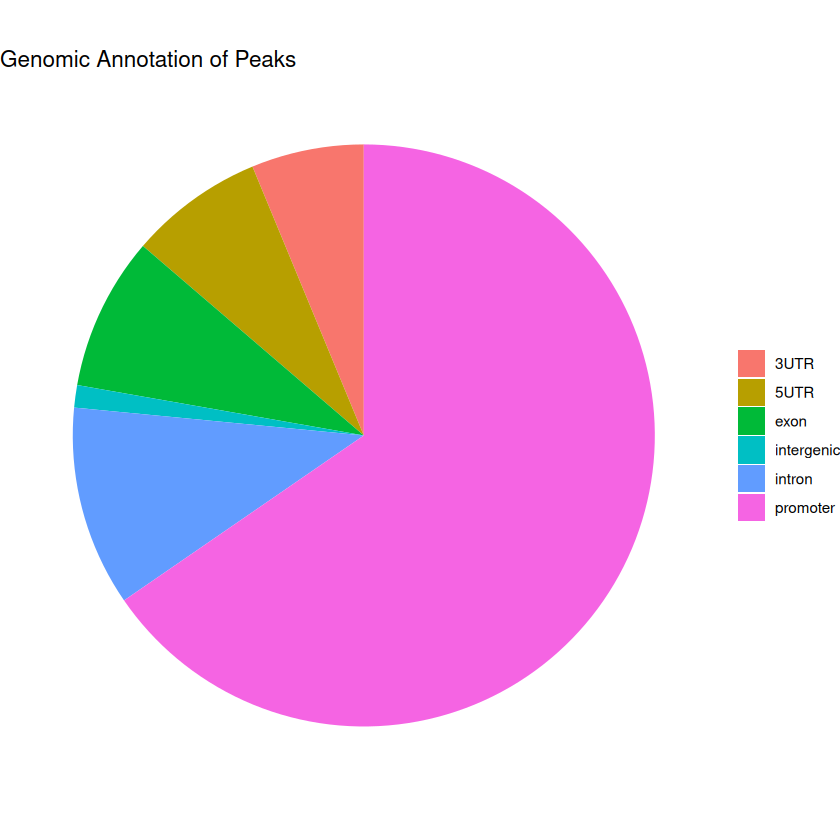

In [8]:
# Load libraries
library(GenomicRanges)
library(GenomicFeatures)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(ggplot2)

# Load TxDb
txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene

# Define genomic feature regions
promoters_gr <- promoters(txdb, upstream = 3000, downstream = 0)
fiveUTR_gr   <- unlist(fiveUTRsByTranscript(txdb, use.names = TRUE))
threeUTR_gr  <- unlist(threeUTRsByTranscript(txdb, use.names = TRUE))
exons_gr     <- unlist(exonsBy(txdb, by = "tx"))
introns_gr   <- unlist(intronsByTranscript(txdb))

# Initialize annotation vector
categories <- rep("", length(peaks_gr))

# Helper function to assign categories with priority
assign_category <- function(query, target_gr, label) {
  hits <- findOverlaps(query, target_gr)
  idx <- queryHits(hits)
  categories[idx[categories[idx] == ""]] <<- label
}

# Assign annotations by priority
assign_category(peaks_gr, promoters_gr, "promoter")
assign_category(peaks_gr, fiveUTR_gr, "5UTR")
assign_category(peaks_gr, threeUTR_gr, "3UTR")
assign_category(peaks_gr, exons_gr, "exon")
assign_category(peaks_gr, introns_gr, "intron")
categories[categories == ""] <- "intergenic"

# Create final annotation data frame
annotated_df <- data.frame(
  peak_name = if (!is.null(mcols(peaks_gr)$name)) mcols(peaks_gr)$name else paste0("peak_", seq_along(peaks_gr)),
  annotation = categories
)

# Print annotation counts
print(table(annotated_df$annotation))

# Create summary for pie chart
annotation_summary <- as.data.frame(table(annotated_df$annotation))
colnames(annotation_summary) <- c("Region", "Count")

# Plot pie chart
ggplot(annotation_summary, aes(x = "", y = Count, fill = Region)) +
  geom_bar(width = 1, stat = "identity") +
  coord_polar(theta = "y") +
  labs(title = "Genomic Annotation of Peaks") +
  theme_void() +
  theme(legend.title = element_blank())


In [9]:
library(ChIPpeakAnno)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(ggplot2)

library(EnsDb.Hsapiens.v86)
ensembl.hs86.transcripts <- transcripts(EnsDb.Hsapiens.v86)

# 1. Convert gene features to GRanges
# annoData <- toGRanges(TxDb.Hsapiens.UCSC.hg38.knownGene, feature = "gene")
# 2. Annotate peaks
# annotatedPeaks <- annotatePeakInBatch(peaks_gr, AnnotationData = annoData)
# head(annotatedPeaks, 2)

# Convert your PEAKS to NCBI style (not the database)
seqlevelsStyle(peaks_gr) <- "NCBI"

# Remove problematic sequences
peaks_gr <- keepStandardChromosomes(peaks_gr, pruning.mode = "coarse")

peaks_ensembl <- annotatePeakInBatch(peaks_gr, 
                                     AnnotationData = ensembl.hs86.transcripts)

write.table(as.data.frame(peaks_ensembl), 
            file = "the.matrix.peaks_and_counts.method1.peak.annotations.ChIPpeakAnno.csv", 
            sep = "\t", 
            row.names = FALSE, 
            quote = FALSE)

head(peaks_ensembl, n = 2)

# https://bioconductor.org/packages/devel/bioc/vignettes/ChIPpeakAnno/inst/doc/ChIPpeakAnno.html

Loading required package: ensembldb

Loading required package: AnnotationFilter


Attaching package: 'ensembldb'


The following object is masked from 'package:dplyr':

    filter


The following object is masked from 'package:stats':

    filter




GRanges object with 2 ranges and 19 metadata columns:
                         seqnames        ranges strand |  mcols.name
                            <Rle>     <IRanges>  <Rle> | <character>
  X00001.ENST00000607769        1 904855-905637      * |      peak_8
  X00002.ENST00000607769        1 907757-908089      * |     peak_10
                         mcols.score mcols.signalValue mcols.pValue
                           <integer>         <numeric>    <numeric>
  X00001.ENST00000607769        1000          1019.687      6.56097
  X00002.ENST00000607769        1000           401.666      5.60406
                         mcols.qValue mcols.peak mcols.X16h_A27_13_1
                            <integer>  <integer>           <integer>
  X00001.ENST00000607769           -1        316                  49
  X00002.ENST00000607769           -1        110                  14
                         mcols.X16h_A27_13_2 mcols.X16h_A27_Cis13_1
                                   <integer>          

In [10]:
table(peaks_ensembl$insideFeature) 


    downstream includeFeature         inside     overlapEnd   overlapStart 
           783             72           3888            300           4248 
      upstream 
          2751 

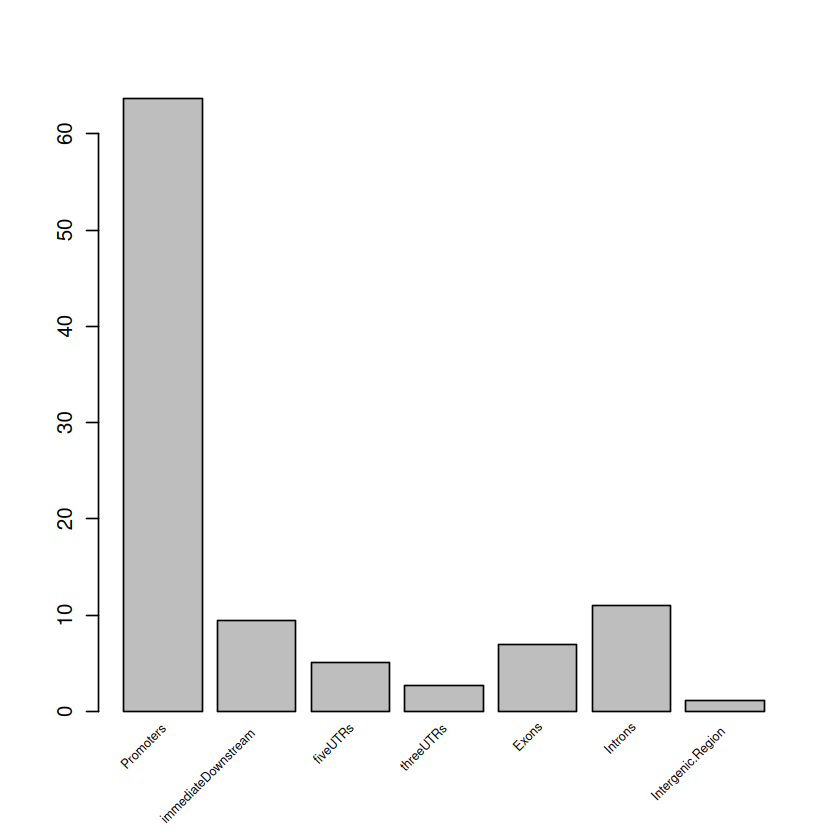

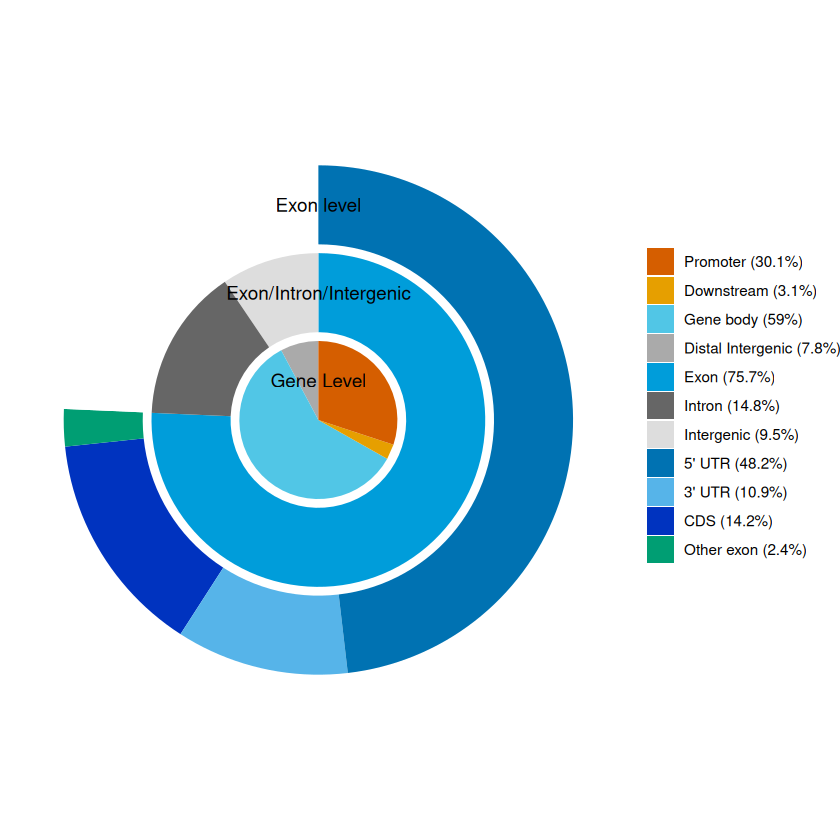

In [11]:
# library(TxDb.Hsapiens.UCSC.hg38.knownGene)

# annotation_data <- transcripts(TxDb.Hsapiens.UCSC.hg38.knownGene)
# binOverFeature(peaks_gr, 
#               featureSite = c("FeatureStart", "FeatureEnd", "bothEnd"),
#               nbins = 20,
#               annotationData = annotation_data,
#              xlab = "peak distance from TSS (bp)", 
#              ylab = "peak count", 
#               main = "Distribution of aggregated peak numbers around TSS")

chromosome_region <- assignChromosomeRegion(peaks_gr,
                                            TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene,
                                            nucleotideLevel = FALSE,
                                            precedence=c("Promoters",
                                                         "immediateDownstream", 
                                                         "fiveUTRs", 
                                                         "threeUTRs",
                                                         "Exons", 
                                                         "Introns"))

# optional helper function to rotate x-axis labels for barplot(): 
# ref: https://stackoverflow.com/questions/10286473/rotating-x-axis-labels-in-r-for-barplot

rotate_x <- function(data, rot_angle) {
  plt <- barplot(data, xaxt = "n")
  text(plt, par("usr")[3], 
       labels = names(data), 
       srt = rot_angle, adj = c(1.1,1.1), 
       xpd = TRUE, cex = 0.6)
}

rotate_x(chromosome_region[["percentage"]], 45)

genomicElementDistribution(peaks_gr, 
                           TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, 
                           promoterRegion = c(upstream=3000, downstream=0)
                           )

In [12]:
# library(UpSetR)
# library(repr)
# library(reactome.db)

# res <- genomicElementUpSetR(peaks_gr,
#                            TxDb.Hsapiens.UCSC.hg38.knownGene)

# options(repr.plot.width = 18, repr.plot.height = 12)

# upset(res[["plotData"]], 
#      nsets = length(colnames(res$plotData)), 
#      nintersects = NA)

# anno_data <- genes(EnsDb.Hsapiens.v86)
# annotated_peaks <- annotatePeakInBatch(peaks_gr,
#                                       AnnotationData = anno_data,
#                                       output = "both")

# enriched_go <- getEnrichedGO(annotated_peaks, 
#                             orgAnn = "org.Hs.eg.db", 
#                             feature_id_type = "ensembl_gene_id")

# enriched_path <- getEnrichedPATH(annotated_peaks,
#                                 orgAnn = "org.Hs.eg.db",
#                                 feature_id_type = "ensembl_gene_id",
#                                 # pathAnn = "reactome.db",
#                                 pathAnn= "KEGGREST")

# enrichmentPlot(enriched_go)
# enrichmentPlot(enriched_path)

# ensembl.hs86.transcript <- transcripts(EnsDb.Hsapiens.v86)
# peaks_ensembl <- annotatePeakInBatch(peaks_gr, 
#                                    AnnotationData = ensembl.hs86.transcript, 
#                                    output = "both")

# head(peaks_ensembl, n = 2)

In [13]:
# library(annotatr)

# Load built-in annotations
# annotations <- c("hg38_genes_promoters", 
#                 "hg38_genes_5UTRs", 
#                 "hg38_genes_3UTRs", 
#                 "hg38_genes_exons", 
#                 "hg38_genes_introns")

# annot_regions <- build_annotations(genome = 'hg38', annotations = annotations)
# cat("Using EnsDb.Hsapiens.v86 directly")

# Extract different genomic features from EnsDb
# edb <- EnsDb.Hsapiens.v86

# Get transcripts, exons, and other features
# transcripts_ensdb <- transcripts(edb)
# exons_ensdb <- exons(edb)
# genes_ensdb <- genes(edb)

In [14]:
library(EnsDb.Hsapiens.v86)

edb <- EnsDb.Hsapiens.v86 # Get your EnsDb object

# You can directly provide the EnsDb object to ChIPseeker
# ChIPseeker's annotatePeak function is designed to handle this.
# Ensure your peaks GRanges object (e.g., macs_peak_gr) is loaded.

# Annotate peaks using the EnsDb object
peak_annotation_cs <- annotatePeak(
  peak = peaks_gr,
  tssRegion = c(-3000, 0), # Define promoter region
  TxDb = edb,                 # Provide the EnsDb object here
  annoDb = "org.Hs.eg.db",    # For gene symbols, if installed
  verbose = FALSE
)

# View summary and convert to data.frame
print(peak_annotation_cs)

annotated_df_cs <- as.data.frame(peak_annotation_cs)
head(annotated_df_cs, 2)

write.table(as.data.frame(peaks_ensembl), 
            file = "the.matrix.peaks_and_counts.method1.peak.annotations.ChIPSeekR.ensdb.csv", 
            sep = "\t", 
            row.names = FALSE, 
            quote = FALSE)

'select()' returned 1:many mapping between keys and columns



Annotated peaks generated by ChIPseeker
11170/11170  peaks were annotated
Genomic Annotation Summary:
              Feature   Frequency
9    Promoter (<=1kb) 50.59982095
10   Promoter (1-2kb)  2.63205013
11   Promoter (2-3kb)  1.76365264
4              5' UTR 11.50402865
3              3' UTR  8.38854073
1            1st Exon  1.84422560
7          Other Exon  8.73769024
2          1st Intron  5.86392122
8        Other Intron  6.77708147
6  Downstream (<=300)  0.05371531
5   Distal Intergenic  1.83527305


,seqnames,start,end,width,strand,mcols.name,mcols.score,mcols.signalValue,mcols.pValue,mcols.qValue,⋯,geneEnd,geneLength,geneStrand,geneId,transcriptId,transcriptBiotype,distanceToTSS,ENTREZID,SYMBOL,GENENAME
,<fct>,<int>,<int>,<int>,<fct>,<chr>,<int>,<dbl>,<dbl>,<int>,⋯,<int>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,1,904855,905637,783,*,peak_8,1000,1019.6869,6.560973,-1,⋯,915976,11143,1,ENSG00000272438,ENST00000607769,lincRNA,21,NA,NA,NA
2,1,907757,908089,333,*,peak_10,1000,401.6661,5.604062,-1,⋯,915976,11143,1,ENSG00000272438,ENST00000607769,lincRNA,2923,NA,NA,NA


In [15]:
# Annotate with a gtf file

In [16]:
gtf_file <- "gencode.v48.basic.annotation.gtf"
txdb_gtf <- makeTxDbFromGFF(gtf_file, format = "gtf")

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
OK



In [17]:
promoters_gr <- promoters(txdb_gtf, upstream = 3000, downstream = 0)
genes_gr     <- genes(txdb_gtf)

In [18]:
exons_gr     <- exons(txdb_gtf)
introns_gr   <- unlist(intronsByTranscript(txdb_gtf))

In [19]:
# 5' UTRs
fiveUTR_gr <- unlist(fiveUTRsByTranscript(txdb_gtf, use.names = TRUE))

# 3' UTRs
threeUTR_gr <- unlist(threeUTRsByTranscript(txdb_gtf, use.names = TRUE))

In [20]:
# Annotations

In [21]:
annoData <- genes_gr  # or exons_gr, introns_gr, etc.
annotatedPeaks <- annotatePeakInBatch(peaks_gr, AnnotationData = annoData)
head(data.frame(annotatedPeaks, 2))

,seqnames,start,end,width,strand,mcols.name,mcols.score,mcols.signalValue,mcols.pValue,mcols.qValue,⋯,peak,feature,start_position,end_position,feature_strand,insideFeature,distancetoFeature,shortestDistance,fromOverlappingOrNearest,X2
,<fct>,<int>,<int>,<int>,<fct>,<chr>,<int>,<dbl>,<dbl>,<int>,⋯,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>
1,1,904855,905637,783,*,peak_8,1000,1019.6869,6.560973,-1,⋯,00001,ENSG00000272438.2,904810,921019,+,inside,45,45,NearestLocation,2
2,1,907757,908089,333,*,peak_10,1000,401.6661,5.604062,-1,⋯,00002,ENSG00000298603.1,908073,910592,-,overlapEnd,2835,16,NearestLocation,2
3,1,923326,923621,296,*,peak_15,1000,590.2833,5.698771,-1,⋯,00003,ENSG00000187634.13,923923,944574,+,upstream,-597,302,NearestLocation,2
4,1,923944,925234,1291,*,peak_16,1000,3103.5669,8.732809,-1,⋯,00004,ENSG00000187634.13,923923,944574,+,inside,21,21,NearestLocation,2
5,1,956842,957420,579,*,peak_19,1000,951.4952,6.953649,-1,⋯,00005,ENSG00000188976.11,944203,959256,-,inside,2414,1836,NearestLocation,2
6,1,961318,961692,375,*,peak_21,1000,528.8220,5.114330,-1,⋯,00006,ENSG00000187961.15,960584,965719,+,inside,734,734,NearestLocation,2


In [22]:
annoData <- promoters_gr  # or exons_gr, introns_gr, etc.
annotatedPeaks <- annotatePeakInBatch(peaks_gr, AnnotationData = annoData)
head(data.frame(annotatedPeaks, 2))

,seqnames,start,end,width,strand,mcols.name,mcols.score,mcols.signalValue,mcols.pValue,mcols.qValue,⋯,peak,feature,start_position,end_position,feature_strand,insideFeature,distancetoFeature,shortestDistance,fromOverlappingOrNearest,X2
,<fct>,<int>,<int>,<int>,<fct>,<chr>,<int>,<dbl>,<dbl>,<int>,⋯,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>
1,1,904855,905637,783,*,peak_8,1000,1019.6869,6.560973,-1,⋯,00001,ENST00000756436.1,901846,904845,+,downstream,3009,10,NearestLocation,2
2,1,907757,908089,333,*,peak_10,1000,401.6661,5.604062,-1,⋯,00002,ENST00000715286.1,908435,911434,+,upstream,-678,346,NearestLocation,2
3,1,923326,923621,296,*,peak_15,1000,590.2833,5.698771,-1,⋯,00003,ENST00000342066.8,922731,925730,+,inside,595,595,NearestLocation,2
4,1,923944,925234,1291,*,peak_16,1000,3103.5669,8.732809,-1,⋯,00004,ENST00000342066.8,922731,925730,+,inside,1213,496,NearestLocation,2
5,1,956842,957420,579,*,peak_19,1000,951.4952,6.953649,-1,⋯,00005,ENST00000338591.8,957584,960583,+,upstream,-742,164,NearestLocation,2
6,1,961318,961692,375,*,peak_21,1000,528.8220,5.114330,-1,⋯,00006,ENST00000327044.7,959257,962256,-,inside,938,564,NearestLocation,2


In [23]:
annoData <- exons_gr   # or exons_gr, introns_gr, etc.
annotatedPeaks <- annotatePeakInBatch(peaks_gr, AnnotationData = annoData)
head(data.frame(annotatedPeaks, 2))

,seqnames,start,end,width,strand,mcols.name,mcols.score,mcols.signalValue,mcols.pValue,mcols.qValue,⋯,peak,feature,start_position,end_position,feature_strand,insideFeature,distancetoFeature,shortestDistance,fromOverlappingOrNearest,X2
,<fct>,<int>,<int>,<int>,<fct>,<chr>,<int>,<dbl>,<dbl>,<int>,⋯,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>
1,1,904855,905637,783,*,peak_8,1000,1019.6869,6.560973,-1,⋯,00001,ann181,904846,904961,+,overlapEnd,9,9,NearestLocation,2
2,1,907757,908089,333,*,peak_10,1000,401.6661,5.604062,-1,⋯,00002,ann185,908066,908212,+,overlapStart,-309,23,NearestLocation,2
3,1,923326,923621,296,*,peak_15,1000,590.2833,5.698771,-1,⋯,00003,ann26288,923275,923353,-,overlapStart,27,27,NearestLocation,2
4,1,923944,925234,1291,*,peak_16,1000,3103.5669,8.732809,-1,⋯,00004,ann202,923923,924948,+,overlapEnd,21,21,NearestLocation,2
5,1,956842,957420,579,*,peak_19,1000,951.4952,6.953649,-1,⋯,00005,ann26309,956894,957025,-,includeFeature,183,52,NearestLocation,2
6,1,961318,961692,375,*,peak_21,1000,528.8220,5.114330,-1,⋯,00006,ann221,961293,961552,+,overlapEnd,25,25,NearestLocation,2


In [24]:
annoData <- introns_gr  # or exons_gr, introns_gr, etc.
annotatedPeaks <- annotatePeakInBatch(peaks_gr, AnnotationData = annoData)
head(data.frame(annotatedPeaks, 2))

,seqnames,start,end,width,strand,mcols.name,mcols.score,mcols.signalValue,mcols.pValue,mcols.qValue,⋯,peak,feature,start_position,end_position,feature_strand,insideFeature,distancetoFeature,shortestDistance,fromOverlappingOrNearest,X2
,<fct>,<int>,<int>,<int>,<fct>,<chr>,<int>,<dbl>,<dbl>,<int>,⋯,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>
1,1,904855,905637,783,*,peak_8,1000,1019.6869,6.560973,-1,⋯,00001,76,904958,911944,+,overlapStart,-103,103,NearestLocation,2
2,1,907757,908089,333,*,peak_10,1000,401.6661,5.604062,-1,⋯,00002,74,908213,915749,+,upstream,-456,124,NearestLocation,2
3,1,907757,908089,333,*,peak_10,1000,401.6661,5.604062,-1,⋯,00002,75,908213,915749,+,upstream,-456,124,NearestLocation,2
4,1,923326,923621,296,*,peak_15,1000,590.2833,5.698771,-1,⋯,00003,7386,923144,923274,-,upstream,-52,52,NearestLocation,2
5,1,923326,923621,296,*,peak_15,1000,590.2833,5.698771,-1,⋯,00003,7387,923144,923274,-,upstream,-52,52,NearestLocation,2
6,1,923326,923621,296,*,peak_15,1000,590.2833,5.698771,-1,⋯,00003,7388,923144,923274,-,upstream,-52,52,NearestLocation,2


In [25]:
annoData <- fiveUTR_gr  # or exons_gr, introns_gr, etc.
annotatedPeaks <- annotatePeakInBatch(peaks_gr, AnnotationData = annoData)
head(data.frame(annotatedPeaks, 2))

,seqnames,start,end,width,strand,mcols.name,mcols.score,mcols.signalValue,mcols.pValue,mcols.qValue,⋯,peak,feature,start_position,end_position,feature_strand,insideFeature,distancetoFeature,shortestDistance,fromOverlappingOrNearest,X2
,<fct>,<int>,<int>,<int>,<fct>,<chr>,<int>,<dbl>,<dbl>,<int>,⋯,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>
1,1,904855,905637,783,*,peak_8,1000,1019.6869,6.560973,-1,⋯,00001,ENST00000616016.5,923923,924431,+,upstream,-19068,18286,NearestLocation,2
2,1,904855,905637,783,*,peak_8,1000,1019.6869,6.560973,-1,⋯,00001,ENST00000618323.5,923923,924431,+,upstream,-19068,18286,NearestLocation,2
3,1,907757,908089,333,*,peak_10,1000,401.6661,5.604062,-1,⋯,00002,ENST00000616016.5,923923,924431,+,upstream,-16166,15834,NearestLocation,2
4,1,907757,908089,333,*,peak_10,1000,401.6661,5.604062,-1,⋯,00002,ENST00000618323.5,923923,924431,+,upstream,-16166,15834,NearestLocation,2
5,1,923326,923621,296,*,peak_15,1000,590.2833,5.698771,-1,⋯,00003,ENST00000616016.5,923923,924431,+,upstream,-597,302,NearestLocation,2
6,1,923326,923621,296,*,peak_15,1000,590.2833,5.698771,-1,⋯,00003,ENST00000618323.5,923923,924431,+,upstream,-597,302,NearestLocation,2


In [26]:
annoData <- threeUTR_gr  # or exons_gr, introns_gr, etc.
annotatedPeaks <- annotatePeakInBatch(peaks_gr, AnnotationData = annoData)
head(data.frame(annotatedPeaks, 2))

,seqnames,start,end,width,strand,mcols.name,mcols.score,mcols.signalValue,mcols.pValue,mcols.qValue,⋯,peak,feature,start_position,end_position,feature_strand,insideFeature,distancetoFeature,shortestDistance,fromOverlappingOrNearest,X2
,<fct>,<int>,<int>,<int>,<fct>,<chr>,<int>,<dbl>,<dbl>,<int>,⋯,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>
1,1,904855,905637,783,*,peak_8,1000,1019.6869,6.560973,-1,⋯,00001,ENST00000616016.5,944154,944574,+,upstream,-39299,38517,NearestLocation,2
2,1,904855,905637,783,*,peak_8,1000,1019.6869,6.560973,-1,⋯,00001,ENST00000618323.5,944154,944574,+,upstream,-39299,38517,NearestLocation,2
3,1,904855,905637,783,*,peak_8,1000,1019.6869,6.560973,-1,⋯,00001,ENST00000342066.8,944154,944574,+,upstream,-39299,38517,NearestLocation,2
4,1,907757,908089,333,*,peak_10,1000,401.6661,5.604062,-1,⋯,00002,ENST00000616016.5,944154,944574,+,upstream,-36397,36065,NearestLocation,2
5,1,907757,908089,333,*,peak_10,1000,401.6661,5.604062,-1,⋯,00002,ENST00000618323.5,944154,944574,+,upstream,-36397,36065,NearestLocation,2
6,1,907757,908089,333,*,peak_10,1000,401.6661,5.604062,-1,⋯,00002,ENST00000342066.8,944154,944574,+,upstream,-36397,36065,NearestLocation,2


In [27]:
# other packages to consider :

# regioneR
# https://www.bioconductor.org/packages/release/bioc/vignettes/regioneR/inst/doc/regioneR.html

# annotatr
# https://bioconductor.org/packages/release/bioc/vignettes/annotatr/inst/doc/annotatr-vignette.html